In [59]:
import pandas as pd
import numpy as np
import anndata as ad
import sgkit as sg
import cellink  as cl
from pathlib import Path
import pickle
import scanpy as sc
import copy
from tqdm import tqdm
from plotnine import *

In [2]:
from cellink.tl._burden_testing import *

In [3]:
from cellink import DonorData

In [4]:
cell_type_col = "cell_label"

In [5]:
gdata = ad.read_h5ad("gdata.h5ad")
gdata.obs = gdata.obs.set_index("id", drop = False)

In [6]:
gdata.varm["annotations_0"]["TSSDistance"].max()

5000.0

In [7]:
donor_key_in_sc_adata = "individual" 

adata = ad.read_h5ad("/s/project/deeprvat/eva/theislab/hackathon24/chr22_OneK1K_cohort_gene_expression_matrix_14_celltypes.h5ad.gz")
adata


AnnData object with n_obs × n_vars = 1272489 × 673
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age'
    var: 'GeneSymbol', 'features'

In [8]:
ddata = DonorData(adata, gdata, "individual")
ddata

[2024-10-10 19:26:39,984] INFO:cellink._core.donordata: Keeping 981/1034 donors
[2024-10-10 19:26:39,984] INFO:cellink._core.donordata: Dropping 53/1034 donors from genetic data
[2024-10-10 19:26:39,985] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Cells (adata)                                          ┃ Donors (gdata)                                         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ View of AnnData object with n_obs × n_vars = 1272489 × │ View of AnnData object with n_obs × n_vars = 981 ×     │
│ 673                                                    │ 143083                                                 │
│     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA',   │     obs: 'id'                                          │
│ 'pool', 'individual', 'percent.mt', 'latent',          │                                                        │
│ 'nCount_SCT', 'nFeature_SCT', 'cell_type',             │                                                        │
│ 'cell_label', 'sex', 'age'                             │                                                        │
│     var: 'GeneSymbol', 'features'                      │     var: 'chrom', 'pos', 'a0', 'a1', 'AF', 'ER2',      │
│                                                        │ 'maf', 'R2', 'contig', 'id', 'id_mask', 'quality'      │
│                                                        │     varm: 'annotations_0', 'annotations_1',            │
│                                                        │ 'annotations_2', 'annotations_3', 'annotations_4',     │
│                                                        │ 'annotations_5', 'annotations_6', 'annotations_7'      │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

### covariates

In [9]:
ddata.aggregate("age", "age", agg_func = "mean") 
ddata.aggregate("sex", "sex", agg_func = "mean") 

/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:280: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [10]:
ddata.gdata.obs

,id,age,sex
id,,,
1_1,1_1,65.0,2.0
2_2,2_2,48.0,2.0
3_3,3_3,53.0,2.0
4_4,4_4,48.0,2.0
6_6,6_6,79.0,2.0
...,...,...,...
1077_1078,1077_1078,61.0,1.0
1078_1079,1078_1079,65.0,1.0
1079_1080,1079_1080,77.0,2.0


In [11]:
# all_burdens = compute_burdens(ddata, max_af=0.05, weight_cols=["DISTANCE", "CADD_PHRED"])
# all_burdens.to_parquet("all_burdens_chr22.parquet")
all_burdens = pd.read_parquet("all_burdens_chr22.parquet")
ddata.gdata.uns["gene_burdens"] = all_burdens

In [12]:
cell_types = ddata.adata.obs[cell_type_col].unique()
cell_types

['CD8 ET', 'CD8 NC', 'CD4 NC', 'Mono C', 'NK', ..., 'DC', 'NK R', 'Platelets', 'CD4 SOX4', 'Erythrocytes']
Length: 16
Categories (16, object): ['B IN', 'B Mem', 'CD4 ET', 'CD4 NC', ..., 'NK', 'NK R', 'Plasma', 'Platelets']

In [13]:
all_res = []
for cell_type in cell_types:
    print(cell_type)
    this_ddata = compute_pseudobulks(ddata, cell_type)
    this_res = run_burden_testing(this_ddata)
    this_res[cell_type_col] = cell_type
    all_res.append(this_res)
all_res = pd.concat(all_res)

CD8 ET
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/500 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  5%|▍         | 23/500 [00:00<00:13, 34.80it/s]/d

CD8 NC
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/474 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  5%|▌         | 24/474 [00:00<00:15, 29.55it/s]/d

CD4 NC
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/529 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  5%|▌         | 27/529 [00:00<00:16, 30.00it/s]/d

Mono C
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/415 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  5%|▍         | 20/415 [00:00<00:11, 34.61it/s]/d

NK
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/485 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  5%|▌         | 25/485 [00:00<00:15, 29.33it/s]/d

B IN
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/455 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  5%|▍         | 22/455 [00:00<00:13, 32.98it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-gen

CD4 ET
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/438 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  4%|▍         | 19/438 [00:00<00:16, 24.86it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-gen

Mono NC
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/366 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  4%|▍         | 14/366 [00:00<00:11, 29.47it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-gen

CD8 S100B
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/413 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  5%|▍         | 20/413 [00:00<00:13, 30.21it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-gen

B Mem
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/428 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  5%|▍         | 20/428 [00:00<00:13, 30.56it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-gen

Plasma
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/303 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  4%|▍         | 12/303 [00:00<00:09, 31.35it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-gen

DC
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/343 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  3%|▎         | 12/343 [00:00<00:09, 34.18it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-gen

NK R
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/341 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  4%|▎         | 12/341 [00:00<00:10, 31.01it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-gen

Platelets
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/306 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  4%|▍         | 12/306 [00:00<00:08, 36.56it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-gen

CD4 SOX4
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  0%|          | 0/309 [00:00<?, ?it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  4%|▍         | 12/309 [00:00<00:10, 29.65it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-gen

Erythrocytes
Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.
  4%|▍         | 8/212 [00:00<00:06, 31.57it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:61: RuntimeWarning: invalid value encountered in multiply
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:68: RuntimeWarning: invalid value encountered in multiply
  9%|▉         | 20/212 [00:00<00:05, 33.04it/s]/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_gwas.py:60: RuntimeWarning: divide by zero encountered in divide
/data/nasif12/home_if12/hoev/gi

In [14]:
all_res["pvalue_corrected"] = all_res["pvalue"] * len(all_res)
all_res["significant"] = all_res["pvalue_corrected"] < 0.05

In [15]:
all_res.to_parquet("all_gene_burden_associations_norm.parquet")

In [60]:
all_res = pd.read_parquet("all_gene_burden_associations_norm.parquet")

In [17]:
all_res.query("significant & burden_type== 'DISTANCE'")

,Gene_burden,burden_type,pvalue,beta,cell_label,pvalue_corrected,significant
0,ENSG00000075234,DISTANCE,2.302263e-06,0.000016,CD4 NC,0.029087,True
0,ENSG00000187905,DISTANCE,9.633641e-07,0.000188,Plasma,0.012171,True


In [18]:
e_genes_per_cell_type = all_res\
    .groupby([cell_type_col, "burden_type"])["significant"].sum()\
    .to_frame(name = "count").reset_index()
e_genes_per_cell_type

,cell_label,burden_type,count
0,B IN,CADD_PHRED,2
1,B IN,DISTANCE,0
2,B Mem,CADD_PHRED,0
3,B Mem,DISTANCE,0
4,CD4 ET,CADD_PHRED,1
5,CD4 ET,DISTANCE,0
6,CD4 NC,CADD_PHRED,5
7,CD4 NC,DISTANCE,1
8,CD4 SOX4,CADD_PHRED,0
9,CD4 SOX4,DISTANCE,0


In [28]:
zero_types = list(e_genes_per_cell_type.groupby("cell_label").sum().query("count ==0").index)

[2024-10-10 21:13:30,610] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


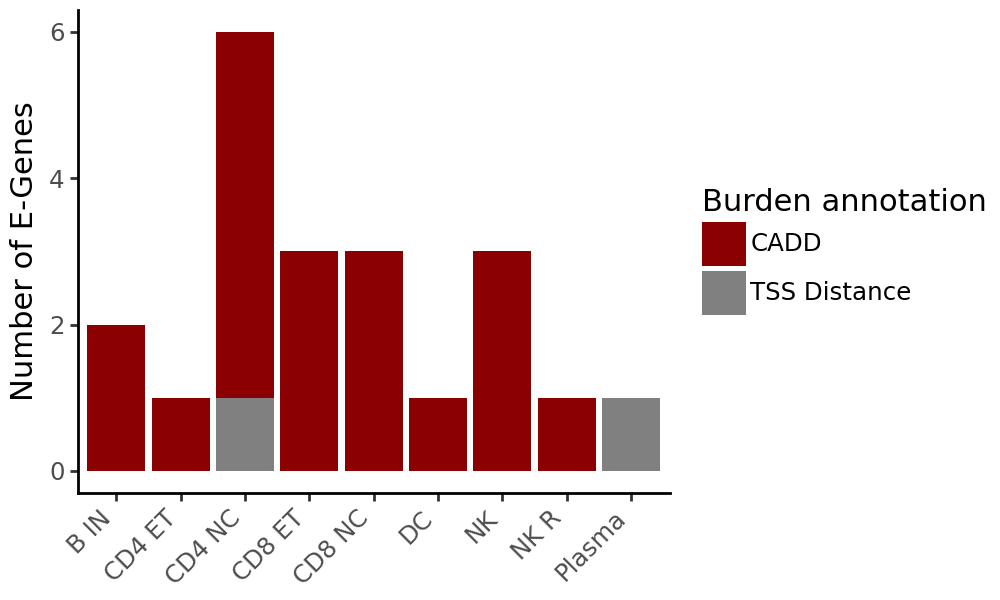

In [61]:
plot = (
    ggplot(e_genes_per_cell_type.query("cell_label not in @zero_types"), 
           aes(x='cell_label', y='count'))  # Specify the x and y variables
    + geom_bar(aes(fill = "burden_type"), stat = "identity")  # Add the boxplot layer
    + theme_classic()  # Optional: use a clean theme
    + theme(axis_text_x = element_text(angle = 45, hjust = 1, vjust = 1), figure_size = (5,3)) 
            #legend_position="none")
    + labs(y = "Number of E-Genes", x = "", fill = "Burden annotation")
    + scale_fill_manual(values = ['darkred', "grey"], labels = ["CADD",  "TSS Distance"])
)
plot

[2024-10-10 19:40:32,984] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


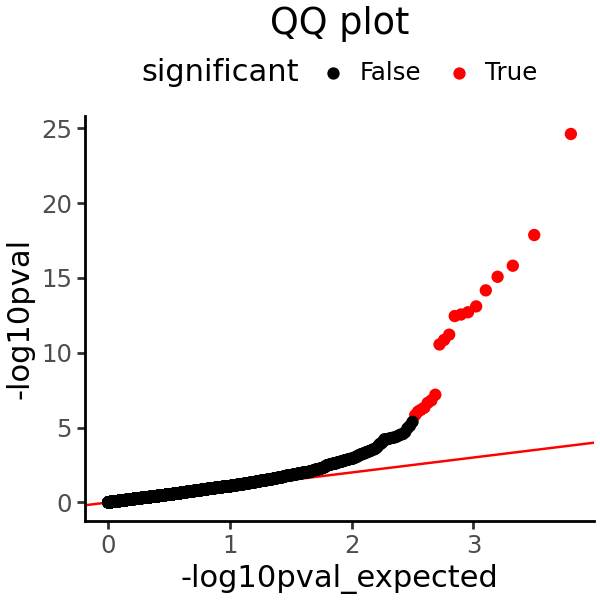

In [39]:
df = all_res.copy().query("burden_type == 'CADD_PHRED'")

df = df.sort_values("pvalue")
df["-log10pval_expected"] = -np.log10(np.arange(1, len(df) + 1) / len(df))

if "-log10pval" not in df.columns:
    df["-log10pval"] = -np.log10(df["pvalue"])

aes_kwargs = dict(x="-log10pval_expected", y="-log10pval")
plot = (
    ggplot(df, aes(**aes_kwargs, color="significant"))
    + labs(title="QQ plot")
    + scale_color_manual(values = ["black", "red"])
    + theme_classic()
    + geom_abline(intercept=0, slope=1, color="red")
    + geom_point()
    + theme(legend_position="top", figure_size = (3,3))
)
plot

In [87]:
ddata.adata.obs.groupby(cell_type_col).size().sort_values()

/scratch/tmp/hoev/ipykernel_1415524/3448583063.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


cell_label
Erythrocytes       680
Plasma            3625
Platelets         4041
CD4 SOX4          4065
DC                8690
NK R              9677
Mono NC          15166
CD8 S100B        34528
Mono C           38233
B Mem            48023
CD4 ET           61786
B IN             82068
CD8 NC          133482
NK              159820
CD8 ET          205077
CD4 NC          463528
dtype: int64

In [66]:
sig_genes_cd4 = all_res.query("cell_label == 'CD4 NC' & significant")["Gene_burden"].unique()
sig_genes_cd4
all_res.query("significant & Gene_burden not in @sig_genes_cd4")

,Gene_burden,burden_type,pvalue,beta,cell_label,pvalue_corrected,significant
0,ENSG00000187905,DISTANCE,9.633641e-07,0.000188,Plasma,0.012171,True


In [44]:
gene_oi = "ENSG00000187905"

In [67]:
all_res.query("Gene_burden == @gene_oi & burden_type == 'DISTANCE'")

,Gene_burden,burden_type,pvalue,beta,cell_label,pvalue_corrected,significant
0,ENSG00000187905,DISTANCE,4.364780e-01,-0.000091,CD8 ET,5514.463312,False
0,ENSG00000187905,DISTANCE,6.917693e-01,-0.000042,CD8 NC,8739.813258,False
0,ENSG00000187905,DISTANCE,3.604805e-01,-0.000120,CD4 NC,4554.310969,False
0,ENSG00000187905,DISTANCE,7.208982e-01,0.000022,Mono C,9107.828178,False
0,ENSG00000187905,DISTANCE,6.070644e-01,0.000054,NK,7669.651712,False
0,ENSG00000187905,DISTANCE,9.076210e-01,-0.000011,B IN,11466.884235,False
0,ENSG00000187905,DISTANCE,7.097806e-01,0.000027,CD4 ET,8967.368283,False
0,ENSG00000187905,DISTANCE,1.524448e-01,0.000061,Mono NC,1925.988184,False
0,ENSG00000187905,DISTANCE,6.397567e-01,0.000028,CD8 S100B,8082.685830,False
0,ENSG00000187905,DISTANCE,1.797661e-01,-0.000093,B Mem,2271.165480,False


In [45]:
all_res.query("significant").groupby("Gene_burden").size().to_frame(name = "Number of Sig. cell types").loc[gene_oi]

Number of Sig. cell types    1
Name: ENSG00000187905, dtype: int64

In [46]:
this_ddata_mono = compute_pseudobulks(ddata, "Plasma")
this_ddata_cd = compute_pseudobulks(ddata, "CD4 NC")

Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.


Normalizing and log1p transforming data


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/_core/donordata.py:282: ImplicitModificationWarning: Setting element `.obsm['pseudo_mean']` of view, initializing view as actual.


In [47]:
y_cd = this_ddata_cd.gdata.obsm["pseudo_mean"][gene_oi] 
y_mono = this_ddata_mono.gdata.obsm["pseudo_mean"][gene_oi]
b = this_ddata_mono.gdata.uns['gene_burdens'].query("Gene == @gene_oi")["CADD_PHRED"]

In [51]:
merged = y_cd.to_frame(name = "CD4 NC").join(y_mono.to_frame(name = "Plasma")).join(b)
merged = merged.reset_index()\
    .melt(id_vars = ["CADD_PHRED", "id"], value_vars = ["CD4 NC","Plasma"], var_name = "Cell type", value_name = "Expression")
merged

,CADD_PHRED,id,Cell type,Expression
0,9.514,1_1,CD4 NC,0.000924
1,0.000,2_2,CD4 NC,0.000000
2,0.000,3_3,CD4 NC,0.002641
3,0.000,4_4,CD4 NC,0.001961
4,0.000,6_6,CD4 NC,0.000885
...,...,...,...,...
1957,0.000,1077_1078,Plasma,0.000000
1958,0.000,1078_1079,Plasma,0.000000
1959,0.000,1079_1080,Plasma,0.000000
1960,3.481,1080_1081,Plasma,0.000000


/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 72 rows containing missing values.


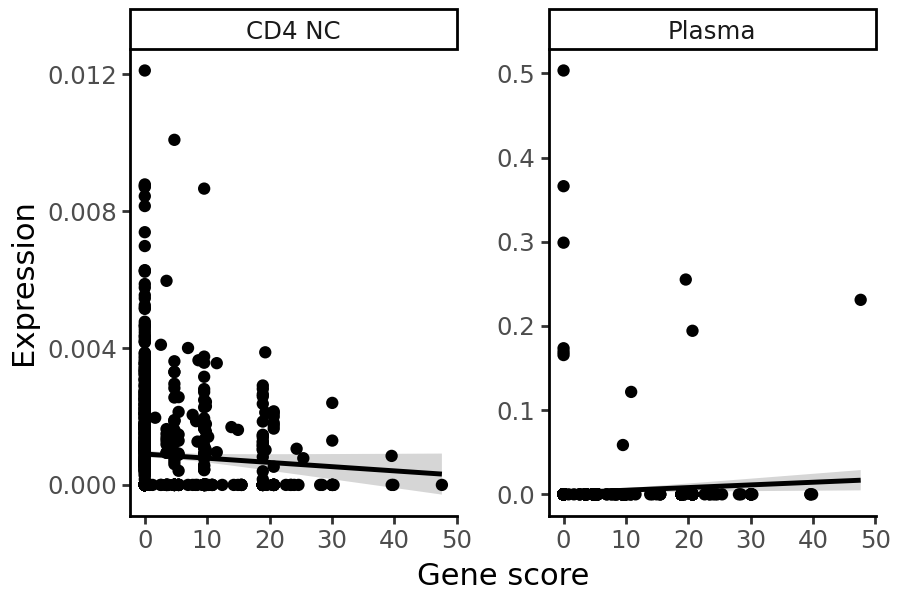

In [58]:
plot = (
    ggplot(merged, aes(x = "CADD_PHRED", y = "Expression"))
    + labs(x = "Gene score")
    + theme_classic()
    + geom_smooth()
    + geom_point()
    + facet_wrap("Cell type", scales = "free")
    + theme(legend_position="top", figure_size = (4.5,3))
)
plot